In [1]:
# importing required libraries 
import re
import pandas as pd

# for pytorch imports
import torch

# for functional dependencies like activation function 
import torch.nn.functional as F

# nn is basic module in Torch which provide different neural network architecture
import torch.nn as nn

# for optimizer
import torch.optim as optim

# for padding .. since the LSTM takes input as sequence so it is said that 
#if we have fixed input string computation will be faster and it will improve performance 
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader

In [2]:
# ハイパーパラメータ
MAX_WORDS_LEN = 512
BATCH_SIZE = 128
EMBEDDING_SIZE = 256
NUM_LAYERS = 1
HIDDEN_SIZE = 128
N_EPOCH = 10

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
# 学習データの準備
from torchtext.datasets import IMDB

train_iter, test_iter = IMDB()

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.transforms import Sequential, VocabTransform, Truncate, ToTensor

tokenizer = get_tokenizer("basic_english")
tokenize = lambda x: tokenizer(re.sub(r'["\'`;:\(\),-]', '', x))
train_text = train_iter.map(lambda x: tokenize(x[1]))
vocab = build_vocab_from_iterator(train_text, specials=('<unk>', '<pad>'), min_freq=200)
vocab.set_default_index(vocab['<unk>'])
# print(vocab.get_stoi())
print(f'vocabulary num: {len(vocab)}')

text_transform = Sequential(
    VocabTransform(vocab),
    Truncate(max_seq_len=MAX_WORDS_LEN),
    ToTensor(padding_value=vocab['<pad>'])
);

def collate_batch(batch):
    texts = text_transform([tokenize(text) for (label, text) in batch])
    labels = torch.FloatTensor([label - 1 for (label, text) in batch])
    raw_text = [text for (label, text) in batch]
    return texts, labels, raw_text

train_dataloader = DataLoader(train_iter, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter, shuffle=True, batch_size=BATCH_SIZE, collate_fn=collate_batch)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Lambda function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


vocabulary num: 2445


In [5]:
def debug_data():
    label, text = next(iter(train_iter))
    print(text, label)
    tokenized_text = tokenize(text)
    print(tokenized_text)
    transformed_text = text_transform(tokenized_text)
    print(transformed_text)

debug_data()

Michael Caine has always claimed that Ashanti was "the only film (he) did purely for the money" as well as "the worst film he ever starred in". Hold on, Michael, weren't you in The Swarm and Hurry Sundown? And weren't both of those films a good deal worse than Ashanti? Perhaps Caine remembers only too begrudgingly the physically punishing demands of filming an action film in searing 130 degrees Fahrenheit temperatures (the director, Richard Fleischer, was hospitalised as a result of sun-stroke during the shoot). What Ashanti actually emerges as is not the career low-point of Michael Caine. Instead, it is a very average chase thriller with a talented cast, exotic locations, boring stretches and a highly formulaic storyline.<br /><br />Dr. David Linderby (Caine) is a W.H.O medic who is left devastated when his black wife Anansa (Beverly Johnson) goes missing during an aid trip to an African tribal village. Linderby gradually realises that his wife has been snatched by slave traders - led

In [6]:
class RNN(nn.Module):
     def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(RNN, self).__init__()
        self.encoder = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, 1)
        
     def forward(self, inputs):
        encoded = self.encoder(inputs)
        output, hidden = self.rnn(encoded)
        pooled = F.max_pool1d(output.permute(0,2,1), output.shape[1]).squeeze(2)
        output = self.decoder(pooled).squeeze()
        return output

model = RNN(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_SIZE,
    hidden_dim=HIDDEN_SIZE,
    num_layers=NUM_LAYERS
)
model = model.to(device)
model

RNN(
  (encoder): Embedding(2445, 256)
  (rnn): GRU(256, 128, batch_first=True)
  (decoder): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
# モデルの訓練と評価
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

train_accs = [0] * N_EPOCH
train_losses = [0] * N_EPOCH
test_accs = [0] * N_EPOCH
test_losses = [0] * N_EPOCH
for epoch in range(N_EPOCH):
    model.train()
    train_total = 0
    train_acc = 0
    train_loss = 0
    for batch in train_dataloader:
        texts, labels, _ = batch
        texts, labels = texts.to(device), labels.to(device)

        # パラメータの勾配をリセット
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        
        acc = binary_accuracy(predictions, labels)
        train_total += 1
        train_acc += acc.item()
        train_loss += loss.item()

    model.eval()
    test_total = 0
    test_acc = 0
    test_loss = 0
    with torch.no_grad():
        for batch in test_dataloader:
            texts, labels, _ = batch
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels)
            acc = binary_accuracy(predictions, labels)

            test_total += 1
            test_acc += acc.item()
            test_loss += loss.item()

    # LossとAccuracyを表示
    train_accs[epoch] = train_acc / train_total
    train_losses[epoch] = train_loss / train_total
    test_accs[epoch] = test_acc / test_total
    test_losses[epoch] = test_loss / test_total
    print(f'Epoch: {epoch+1}, Train Acc: {train_accs[epoch]:.3f}, Train Loss: {train_losses[epoch]:.3f}, Test Acc: {test_accs[epoch]:.3f}, Test Loss: {test_losses[epoch]:.3f}')

Epoch: 1, Train Acc: 0.709, Train Loss: 0.569, Test Acc: 0.501, Test Loss: 0.737
Epoch: 2, Train Acc: 0.767, Train Loss: 0.525, Test Acc: 0.733, Test Loss: 0.566
Epoch: 3, Train Acc: 0.818, Train Loss: 0.452, Test Acc: 0.761, Test Loss: 0.519
Epoch: 4, Train Acc: 0.848, Train Loss: 0.401, Test Acc: 0.825, Test Loss: 0.411
Epoch: 5, Train Acc: 0.876, Train Loss: 0.323, Test Acc: 0.844, Test Loss: 0.368
Epoch: 6, Train Acc: 0.896, Train Loss: 0.267, Test Acc: 0.853, Test Loss: 0.347
Epoch: 7, Train Acc: 0.914, Train Loss: 0.225, Test Acc: 0.861, Test Loss: 0.339
Epoch: 8, Train Acc: 0.929, Train Loss: 0.190, Test Acc: 0.863, Test Loss: 0.335
Epoch: 9, Train Acc: 0.941, Train Loss: 0.161, Test Acc: 0.874, Test Loss: 0.312
Epoch: 10, Train Acc: 0.956, Train Loss: 0.126, Test Acc: 0.872, Test Loss: 0.335


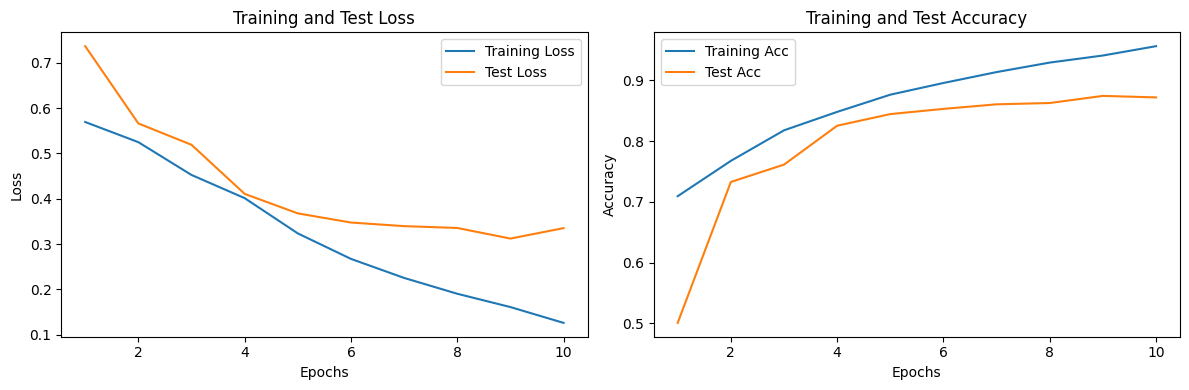

In [8]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, test_losses, train_accs, test_accs):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Training Acc')
    plt.plot(epochs, test_accs, label='Test Acc')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(train_losses, test_losses, train_accs, test_accs)

In [9]:
model.eval()
test_data = next(iter(test_dataloader))
texts, labels, raw_text = test_data
texts = texts.to(device)
predictions = model(texts)
results = [(raw_text[i], labels[i].item(), f"{torch.sigmoid(pred):.3f}") for i, pred in enumerate(predictions)]
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', None)
df = pd.DataFrame(results, columns=['text', 'label', 'pred'])
df

,text,label,pred
0,"This movie is such a total waste of time. I can't understand anyone sitting through this piece of trash. Oh, I would have loved it when I was seven years old. I think a seven year old child may have written and directed it.<br /><br />There's no script, no acting, just rubbish. The best acting is that by the fighting roosters. I think I could whip these ninjas and I am not someone you'd consider tough. Totally unconvincing and did not spark the least bit of interest. I was yawning, and laugh...",0.0,0.045
1,"This film is about a grieving wife who lost her husband through suicide. She is tormented by her son who refused to speak after that.<br /><br />Child grief is rarely explored on film, so it is refreshing to see a film like Addison's Wall. However, due to the very nature of the film, there is no tension or drama. Apart from a few key emotional moments, everything in the film is very plain. The abrupt ending that does not solve any mysteries certainly do not help the film to be more watchable...",0.0,0.979
2,"Oh dear! The BBC is not about to be knocked off its pedestal for absorbing period dramas by this one. I agree this novel of Jane Austens is the difficult to portray particularly to a modern audience, the heroine is hardly a Elizabeth Bennet, even Edmund is not calculated to cause female hearts to skip a beat. However I must say I was hoping for an improvement on the last and was sadly disappointed. The basic story was preserved, but the dialogue was so altered that all that was Jane Austen's...",0.0,0.065
3,"I have little to no interest in seeing another awful movie, that totally lacks anything new creative or funny, abusing the National Lampoon tag. How ever something caught my eye in the cast of this movie. I see Danielle Fishel's name i'm a big fan of boy meets world! But the movies shes in are awful. More so as a fan i'm not rewarded by seeing her terrible movies with the treasure of bare breast. So this is where my question comes in.<br /><br />Has anyone seen this movie? And if so Does Dan...",0.0,0.014
4,"Yes this movie is obviously trying to be a Conan the Barbarian, and what amazes me is that this is a sequel (the people demanded another one?). The first part of the flick is a flashback showing the original. From what I saw it doesn't look worth checking out (and apparently Ator always kills a huge puppet in his movies). Well now Ator lives at the ends of the earth with his mute sidekick Thong. A girl seeks his help as this evil dude has her father in his custody. Let me just say this bad g...",0.0,0.201
5,"What is wrong with CURACAO ( Also known as DEADLY CURRENTS though what the reasonn for the name change is I have no idea ) can probably be summed up where a woman says to her lover :<br /><br />"" Keep it down baby , I'm trying to sleep "" <br /><br />It's not the dialogue that's the problem or the way it's delivered , it's the fact the actress has has a Central European accent . Nothing wrong with that until it's revealed her character is from Philidelphia in the United States ! This what str...",0.0,0.070
6,"A nicely evoked 1930s setting provides much interest for a viewer in the early 21st century; unfortunately, ""London Belongs to Me"" has little else to recommend it besides lashings of quaint English charm. All of the problems rest with the deeply unfocused story. The main plot concerns the actions of young lad Richard Attenborough, the problems he gets into and how the community in which he lives bands together to save him from society's laws. Or something. The main issue here is that Attenbo...",0.0,0.859
7,"It's hard to believe that a movie this bad wasn't produced once, but four times! Most movies require a certain `suspension of reality' to enjoy, but this one takes it just too far. The basic scenario is an Air Force pilot who is shot down over a `Middle Eastern' country. The US government drags its feet in recovering him, leading the Pilot's son (Doug Masters) to attempt a re

In [10]:
!sudo apt-get install -y graphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [11]:
from torchviz import make_dot
image = make_dot(predictions, params=dict(model.named_parameters()))
image.format = "png"
image.render("images/GRU")

'images/GRU.png'